In [ ]:
# ..... compute metacells ..... #

In [2]:
library(Seurat)
library(SingleCellExperiment)
library(metacell)

In [3]:
# load cell cycle genes
load('cc.genes.rda')
head(cc.genes)
length(cc.genes$g2m.genes)

$s.genes
 [1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"    

$g2m.genes
 [1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

[1] 54

In [4]:
if(!dir.exists("testdb")) dir.create("testdb/")
scdb_init("testdb/", force_reinit = T)

if(!dir.exists("figs")) dir.create("figs/")
scfigs_init("figs/")

initializing scdb to testdb/



In [32]:
# load data
file0 = paste0('stage32_integrated_cca.rds')
seurat_obj = readRDS(file0)
seurat_obj

An object of class Seurat 
34614 features across 21401 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [33]:
# convert to SCE and metacell umi object
sce = SingleCellExperiment(list(counts = seurat_obj@assays$RNA@counts), 
                           colData = DataFrame(seurat_obj@meta.data))

mat = scm_import_sce_to_mat(sce)
print(dim(mat@mat))

scdb_add_mat('test', mat)

[1] 17007 21401


In [34]:
# load data and generate metacells #
mat = scdb_mat("test")
print(dim(mat@mat))

nms = c(rownames(mat@mat), rownames(mat@ignore_gmat))
# ig_genes = c(grep("^RPS", nms, v=T), grep("^RPL",nms,v=T))
ig_genes = c(unlist(cc.genes$g2m.genes), unlist(cc.genes$s.genes))

bad_genes = unique(c(grep("^MT-", nms, v=T), grep("^MTMR", nms, v=T),
                     grep("^MTND", nms, v=T),"TMSB4X", ig_genes))

tail(bad_genes)

[1] 17007 21401


[1] "USP1"   "CLSPN"  "POLA1"  "CHAF1B" "BRIP1"  "E2F8"

In [35]:
mcell_mat_ignore_genes(new_mat_id="test", mat_id="test", bad_genes, reverse=F) 
# mcell_mat_ignore_small_cells("test", "test", 800)

mcell_plot_umis_per_cell("test")
mcell_add_gene_stat(gstat_id = 'test', mat_id = 'test', force = T)

# gene set filter
mcell_gset_filter_varmean(gset_id="test_feats", gstat_id="test", T_vm=0.08, force_new=T)
mcell_gset_filter_cov(gset_id = "test_feats", gstat_id="test", T_tot=100, T_top3=2)

# plot gene stats
mcell_plot_gstats(gstat_id="test", gset_id="test_feats")

[1] 300

Calculating gene statistics... 

will downsamp

done downsamp

will gen mat_n

done gen mat_n

done computing basic gstat, will compute trends

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


..done


png 
  2

In [36]:
# build similarity graph
mcell_add_cgraph_from_mat_bknn(mat_id="test", gset_id = "test_feats", 
                graph_id="test_graph", K=100, dsamp=T)

# get co-clustering graph
mcell_coclust_from_graph_resamp(coc_id="test_coc500", graph_id="test_graph",
                min_mc_size=20, p_resamp=0.75, n_resamp=500)

# build new similarity graph
mcell_mc_from_coclust_balanced(coc_id="test_coc500", mat_id= "test",
                mc_id= "test_mc", K=30, min_mc_size=30, alpha=2)

# remove outliers
mcell_plot_outlier_heatmap(mc_id="test_mc", mat_id = "test", T_lfc=3)
mcell_mc_split_filt(new_mc_id="test_mc_f", mc_id="test_mc", 
            mat_id="test", T_lfc=3, plot_mats=F)

# get markers for metacells
mcell_gset_from_mc_markers(gset_id="test_markers", mc_id="test_mc_f")

will downsample the matrix, N= 750

will build balanced knn graph on 21401 cells and 1715 genes, this can be a bit heavy for >20,000 cells

sim graph is missing 170 nodes, out of 21401

running bootstrap to generate cocluster

done resampling

Warning message in mcell_coclust_filt_by_k_deg(coc_id, K, alpha):
“NAs introduced by coercion”
filtered 10954054 left with 1832658 based on co-cluster imbalance

building metacell object, #mc 207

add batch counts

compute footprints

compute absolute ps

compute coverage ps

reordering metacells by hclust and most variable two markers

reorder on MECOM vs AKAP6



png 
  2

starting split outliers 

splitting metacell 117

add batch counts

compute footprints

compute absolute ps

compute coverage ps



In [37]:
# ..... get colors for metacells ..... #
# plot metacell heatmap
mc_colorize_default(mc_id="test_mc_f")
mcell_mc_plot_marks(mc_id="test_mc_f", gset_id="test_markers", mat_id="test")

setting fig h to 1000 md levels 0 num of marks 190



In [38]:
# 2D projection
mcell_mc2d_force_knn(mc2d_id="test_2dproj",mc_id="test_mc_f", graph_id="test_graph")
tgconfig::set_param("mcell_mc2d_height",1000, "metacell")
tgconfig::set_param("mcell_mc2d_width",1000, "metacell")
mcell_mc2d_plot(mc2d_id="test_2dproj")

comp mc graph using the graph test_graph and K 20

Missing coordinates in some cells that are not ourliers or ignored - check this out! (total 4 cells are missing, maybe you used the wrong graph object? first nodes stage32_sample10_GCCATGGAGGTGCGAT-1stage32_sample10_TATCTGTAGTTCACTG-1stage32_sample10_TGAATGCAGGACCCAA-1stage32_sample12_ACGTAACAGCGATGGT-1



png 
  2

In [39]:
# plot hierarchical clustering - confusion matrix
mc_hc = mcell_mc_hclust_confu(mc_id="test_mc_f", graph_id="test_graph")
mc_sup = mcell_mc_hierarchy(mc_id="test_mc_f", mc_hc=mc_hc, T_gap=0.04)
mcell_mc_plot_hierarchy(mc_id="test_mc_f", graph_id="test_graph", 
                    mc_order=mc_hc$order, sup_mc = mc_sup, 
                    width=2800, heigh=2000, min_nmc=2)

png 
  2

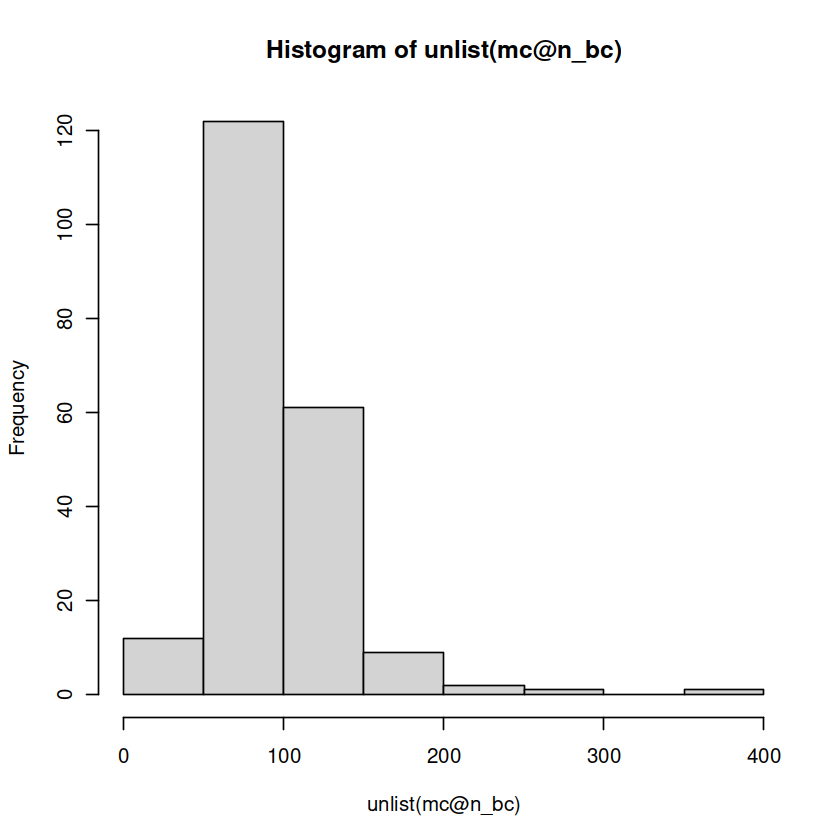

In [40]:
mc = scdb_mc("test_mc_f")
hist(unlist(mc@n_bc))

In [41]:
# save final list of metacells
mc = scdb_mc("test_mc_f")
table1 = mc@mc
newdf = data.frame(barcode = names(table1), metacell = unlist(table1))
rownames(newdf) = NULL

# newdf$celltype = NA
# newdf$celltype <- mm$predicted[match(names(mc@mc), rownames(mm))]

newdf[1,]
write.table(newdf, file = paste0('stage32_metacell.csv'),
            sep = ',', row.names = F, col.names = T, quote = F)

barcode                            metacell
1 stage32_sample5_AAACCCACATACTGTG-1 1